In [64]:
import pandas as pd
from tqdm import tqdm  
import numpy as np
import nltk
import copy
import pickle
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize

In [65]:
data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")

## Add Date

In [26]:
# xplore = pd.read_csv("../../../data/filtered/xplore.csv")
# acm = pd.read_csv("../../../data/filtered/filtered_acm_data.csv")
# science_direct = pd.read_csv("../../../data/filtered/science_direct_filtered_data.csv")

In [27]:
# # join data with the xplore, acm and science direct data as left join
# data = data.join(xplore.set_index("title"), on="title", how="left", rsuffix="_xplore")
# data = data.join(acm.set_index("title"), on="title", how="left", rsuffix="_acm")
# data = data.join(science_direct.set_index("title"), on="title", how="left", rsuffix="_science_direct")

## Tokenization & Filtering

In [66]:
# new column with tokenized abstract
data["tokenized_abstract"] = data["processed_abstract"].apply(word_tokenize)
tokens = data["tokenized_abstract"].tolist()

# pos tagging to the tokenized words
pos_tagged_tokens = []
for token in tqdm(tokens):
    pos_tagged_tokens.append(nltk.pos_tag(token))

# keep only the nouns, verbs and adjectives
nouns_verbs = []
for pos_tagged_token in tqdm(pos_tagged_tokens):
    nouns_verbs.append([token[0] for token in pos_tagged_token if token[1] in ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "JJ", "JJR", "JJS"]])

# remove tokens that are less than 2 characters
tokens = [[token for token in noun if len(token) > 2] for noun in nouns_verbs]

100%|██████████| 363/363 [00:00<00:00, 54405.30it/s]


## Bigrams

In [67]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 
finder = BigramCollocationFinder.from_documents(tokens) 

# only bigrams that appear 5+ times (after several trials, 5 was the best number)
finder.apply_freq_filter(5) 

# return the 100 bigrams with the highest PMI
mwt = finder.nbest(bigram_measures.dice, 100) 

# remove tuples that contain: ('artificial', 'intelligence'), ('machine', 'learning'), ('deep', 'learning')
mwt = [t for t in mwt if t not in [('artificial', 'intelligence'), ('machine', 'learning'), ('deep', 'learning')]]

In [68]:
def collapse_tokens(token_list, mwt):
    '''
        This function takes a list of tokens and collapses the multi-word tokens (MWTs) into a single token.
    
        Parameters:
            token_list (list): A list of tokens
            mwt (list): A list of multi-word tokens

        Returns:
            res_token (list): A list of tokens with MWTs collapsed
    '''
    token_list = copy.copy(token_list)
    res_token = []
    while(len(token_list)>1):
        if (token_list[0],token_list[1]) in mwt:
            res_token.append(f'{token_list.pop(0)}_{token_list.pop(0)}')
        else:
            res_token.append(token_list.pop(0))
    
    if len(token_list) == 1:
        res_token.append(token_list.pop(0))

    return res_token

In [69]:
coll_tokens = [collapse_tokens(token_list, mwt) for token_list in tqdm(tokens)]

  0%|          | 0/363 [00:00<?, ?it/s]

100%|██████████| 363/363 [00:00<00:00, 3775.43it/s]


In [70]:
def cv_token_return(doc):
    return doc

In [71]:
wordvect = CountVectorizer(analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=2) # create a word vectorizer object
dtm = wordvect.fit_transform(coll_tokens) # create a document term matrix

/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [72]:
data = zip(wordvect.get_feature_names_out(),
    np.asarray(dtm.sum(axis=0)).ravel())

df = pd.DataFrame(data, columns =['Word', 'Frequency'])
df.sort_values(by=['Frequency'], inplace=True, ascending=False)
print(df)

             Word  Frequency
358          data        125
1561       system        124
301   consumption         97
867           iot         93
1176        power         92
...           ...        ...
490     emergency          2
489     emergence          2
487         embed          2
485       element          2
876        jetson          2

[1753 rows x 2 columns]


## DTM

In [73]:
vocab = df.Word.to_list()[20:] # ignore the top 20 words

wordvect = CountVectorizer(vocabulary = vocab, analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=3, stop_words="english", max_df=0.98)
dtm = wordvect.fit_transform(coll_tokens)

/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


## LDA

In [74]:
for i in range(10):
    lda_model = LatentDirichletAllocation(n_components=6,               # Number of topics
                                        max_iter=250, # Max learning iterations
                                        learning_method='batch',   
                                        random_state=100+i, # Random state
                                        batch_size=128,  # n docs in each learning iter
                                        evaluate_every = 10, # compute perplexity every n iters, default: Don't
                                        n_jobs = -1, # Use all available CPUs
                                        )

    lda_output = lda_model.fit_transform(dtm)
    pickle.dump(lda_model, open(f"lda_model_{i}.pkl", "wb"))
    pickle.dump(lda_output, open(f"lda_output_{i}.pkl", "wb"))

# lda_output # document-topic matrix (document x topic)
# lda_model.components_ # topic-term matrix (topic x term) 

In [75]:
# obj0, obj1, obj2 are created here...
pickle.dump(wordvect, open("wordvect.pickel", "wb"))
pickle.dump(dtm, open("dtm.pickel", "wb"))

## Topics

In [76]:
def show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=14):
    ''' 
        This function returns the top n keywords for each topic in a dataframe.

        Parameters:
            vectorizer (CountVectorizer): A CountVectorizer object
            lda_model (LatentDirichletAllocation): A LatentDirichletAllocation object
            n_words (int): The number of keywords to return for each topic

        Returns:
            topic_keywords (list): A list of the top n keywords for each topic
    '''
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [77]:
topic_keywords = show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=15)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,buildings,applications,environment,building,smart_cities,waste,study,communication,network,networks,detection,green,smart_city,environmental,cyber
Topic 1,devices,computing,new,computational,human,resources,value,using,values,techniques,cloud,offloading,tinyml,review,solutions
Topic 2,internet,production,approach,efficiency,deep,sources,intelligence,key,demand,load,accuracy,used,networks,multiple,neural
Topic 3,network,optimization,demand,machine,green,wireless,electricity,communication,improve,urban,scheduling,reliability,load,electric,various
Topic 4,model,scheduling,challenges,optimal,monitoring,smart_cities,enterprises,new,device,architecture,strategy,driving,climate,detection,future
Topic 5,production,wind,process,building,electricity,technologies,forecasting,manufacturing,method,used,analysis,resource,deep,techniques,smart_grid


### Silhouette Score

In [102]:
from sklearn.metrics import silhouette_score

silhouette_scores = []  
# read the lda_output saved (lda_output_{i}.pkl) from 1 to 10
for i in range(0,10):
    lda_output = pd.read_pickle(f'lda_output_{i}.pkl')

    topic_assignments = np.argmax(lda_output, axis=1)
    silhouette = silhouette_score(dtm, topic_assignments)
    silhouette_scores.append(silhouette)

silhouette_score = np.mean(silhouette_scores)
print(f"Silhouette Score: {silhouette_score}")


Silhouette Score: -0.015287837153405362


## Visualisation

In [79]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

pyLDAvis.lda_model.prepare(lda_model, dtm, wordvect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.139771  0.076118       1        1  19.700459
3      0.089394 -0.096476       2        1  18.914245
5     -0.003655 -0.113802       3        1  16.515088
4     -0.067582 -0.036313       4        1  16.231891
1     -0.150403  0.025210       5        1  14.862300
2     -0.007525  0.145263       6        1  13.776017, topic_info=            Term       Freq      Total Category  logprob  loglift
2     production  43.000000  43.000000  Default  30.0000  30.0000
10     buildings  35.000000  35.000000  Default  29.0000  29.0000
15       devices  33.000000  33.000000  Default  28.0000  28.0000
14      building  33.000000  33.000000  Default  27.0000  27.0000
12   electricity  34.000000  34.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
123      vehicle   5.113998  13.476136   Topic6  -5.5860   1.0133
121    different   5.113170  13.533510   Topic6  -5.5861   1.0089
4          model   5.941181  42.483768   Topic6  -5.4360   0.0150
25        sensor   5.114097  28.812954   Topic6  -5.5859   0.2534
48    smart_grid   5.113971  21.162053   Topic6  -5.5860   0.5620

[398 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
1148      4  0.883306                 account
125       1  0.149002                accuracy
125       3  0.149002                accuracy
125       5  0.149002                accuracy
125       6  0.596008                accuracy
...     ...       ...                     ...
309       1  0.257537  wireless_communication
309       2  0.643842  wireless_communication
236       2  0.697969       wireless_networks
236       3  0.232656       wireless_networks
731       4  0.942228                workload

[720 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 6, 5, 2, 3])

## Wordclouds

Topic#  1
smart_cities,buildings,applications,methods,communication,production,quality,wireless,various,tools,urban,city,home,approaches,device,wind,used,mobile,industry,blockchain,network,model,devices,operation,global



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  2
architecture,electricity,scheduling,cloud,internet,optimisation,technologies,detection,strategies,waste,deep,production,key,computing,resource,strategy,economic,mec,techniques,utilities,day,manufacturing,economy,maintenance,improve



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  3
devices,building,green,process,monitoring,networks,computing,network,sensor,intelligence,approach,integrated,based,strategy,user,operations,applications,cyber,temperature,computation,platform,information,community,resources,environmental



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  4
model,green,parameters,optimal,framework,software,performance,driving,environment,sensor,various,potential,effective,simulation,using,comfort,achieve,sensing,lighting,vehicle,indoor,impact,crop,cycle,greenhouse



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  5
new,deep,forecasting,wind,using,machine,solar_power,value,materials,production,optimization,used,solutions,method,computational,techniques,human,scheduling,values,plant,research,climate,sources,future,low



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  6
demand,machine,electricity,smart_grid,engineering,error,dsm,intelligent,variables,research,storage,networks,urban,students,production,operation,efficient,integrated,network,key,inference,green,vehicles,based,sources



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


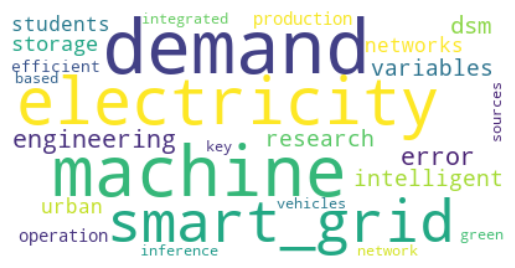

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

terms_count = 25
terms = wordvect.get_feature_names_out()

for idx,topic in enumerate(lda_model.components_):    
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}
    
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]    
    wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
                        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                        contour_width=3,contour_color='black')
    wcloud.generate_from_frequencies(dict_word_frequency)       
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("Topic#"+str(idx+1)+".png", format="png")

In [42]:
#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels) # labels for each topic

['smart_cities.buildings.applications.methods.communication', 'architecture.electricity.scheduling.cloud.internet', 'devices.building.green.process.monitoring', 'model.green.parameters.optimal.framework', 'new.deep.forecasting.wind.using', 'demand.machine.electricity.smart_grid.engineering']


In [43]:
import random
data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")
my_sample = random.sample(range(1, len(data)), 3)

print(data.abstract[my_sample[0]] + "\n")
print(data.abstract[my_sample[1]] + "\n")
print(data.abstract[my_sample[2]] + "\n")

Electricity is an essential component in modern life and the economy, it has promoted the development of so-called industrial era over an extended period of time, and actual information era; however organisms such as WEC1, WWAP2 and ONU SDG3 consider the automation of the current power system model as an unsustainable energy system model for the 21st century because renewable energy sources alone will not be sufficient to meet the large increase of the energy demand and fulfill it in 2030. We are in the knowledge era, and it has said that “artificial intelligence is the new electricity” [1]. This sets enormous challenges for implementation of a new model for the infrastructure, the acquisition and use of the smart electricity grid (Smart Grid) in Ecuador where power is required to be affordable, reliable and sustainable. It describes the current situation, and presents the status of implementation of this concept, to then be able to structure the foundations of a model based on artific

In [44]:
vizDataFrame = pd.DataFrame({'Text_1': lda_output[my_sample[0],], 
                             'Text_2': lda_output[my_sample[1],],
                             'Text_3': lda_output[my_sample[2],]})

vizDataFrame.index = topic_labels

vizDataFrame

,Text_1,Text_2,Text_3
smart_cities.buildings.applications.methods.communication,0.007282,0.011199,0.007984
architecture.electricity.scheduling.cloud.internet,0.007321,0.943919,0.007959
devices.building.green.process.monitoring,0.007325,0.011283,0.007946
model.green.parameters.optimal.framework,0.463582,0.011222,0.007951
new.deep.forecasting.wind.using,0.327995,0.011213,0.007942
demand.machine.electricity.smart_grid.engineering,0.186495,0.011163,0.960217


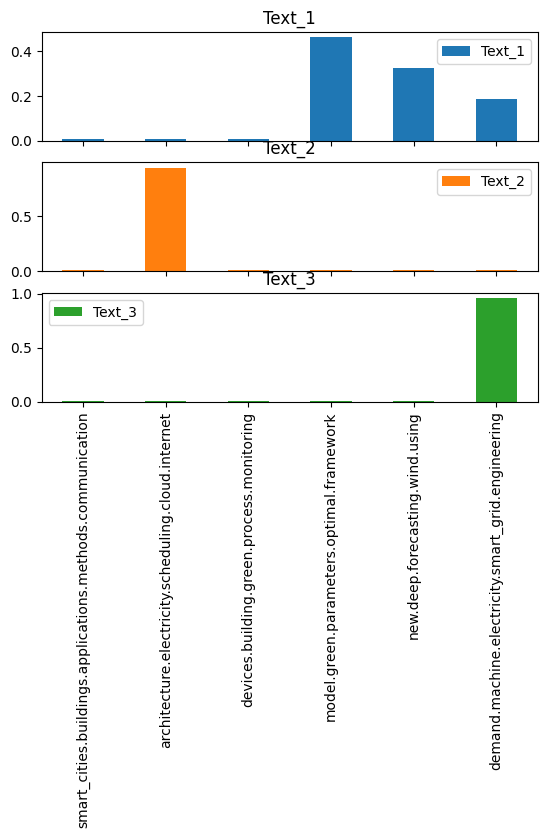

In [45]:
axes = vizDataFrame.plot.bar(rot=90, subplots=True)
axes[1].legend(loc=None) 

In [46]:
#Topic Importance
topicProportions = np.sum(lda_output, axis=0)/lda_output.shape[0]
topicProportions_df = pd.DataFrame({'Topic': topic_labels, 'Mean_Prob': topicProportions})
topicProportions_df.sort_values(by=['Mean_Prob'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df)

                                               Topic  Mean_Prob
0  smart_cities.buildings.applications.methods.co...   0.198265
4                    new.deep.forecasting.wind.using   0.186961
2          devices.building.green.process.monitoring   0.169915
1  architecture.electricity.scheduling.cloud.inte...   0.159024
3           model.green.parameters.optimal.framework   0.151114
5  demand.machine.electricity.smart_grid.engineering   0.134722


In [47]:
#Rank-1 Method
num_topics = 8

countsOfPrimaryTopics = np.zeros(num_topics)

for row in lda_output:
    important_topic = (np.argsort(row)[::-1])[0]
    countsOfPrimaryTopics[important_topic] += 1

topicProportions_df_rank_1 = pd.DataFrame({'Topic': topic_labels, 'Count': countsOfPrimaryTopics})
topicProportions_df_rank_1.sort_values(by=['Count'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df_rank_1)

ValueError: All arrays must be of the same length

In [ ]:
#document distribution over time
import string
from matplotlib import cm

cmap = cm.get_cmap('Spectral')
data["decade"] = data.date.apply(lambda x: x.strip()[0:3] + "0")

# Combine the 2D array with the DataFrame column using Pandas' concat function
combined_array = pd.concat([pd.DataFrame(lda_output, columns=topic_labels), data["decade"]], axis=1)
aggregated_data = combined_array.groupby('decade').mean().reset_index()
aggregated_data.set_index('decade', inplace=True)

# Create a stacked bar chart
aggregated_data.plot.area(stacked=True,colormap=cmap, legend='reverse').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',

)

# Optional: Customize the plot
import matplotlib.pyplot as plt

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Stacked Bar Chart')

plt.show()

/var/folders/xn/ds2yjvkj1yb_392m893dr1sm0000gn/T/ipykernel_37194/38329428.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


AttributeError: 'DataFrame' object has no attribute 'date'

In [ ]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# pip install tmtoolkit
# lda_model - LatentDirichletAllocation()
# vect - CountVectorizer()
# texts - the list of tokenized words
metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=lda_model.components_, 
                        dtm=dtm, 
                        vocab=np.array([x for x in wordvect.get_feature_names_out()]), 
                        texts=data.text.values)

AttributeError: 'DataFrame' object has no attribute 'text'